<a href="https://colab.research.google.com/github/Rohith-Rongali/IMP/blob/main/IMP_DT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn.utils.prune as prune

from copy import deepcopy

from tqdm import tqdm
import os

import numpy as np
import matplotlib.pyplot as plt

from types import SimpleNamespace

# Data functions

In [2]:
def generate_data(data_config):
    # n = 128
    # k = 7
    num_points = data_config.num_points
    n = data_config.n
    k = data_config.k
    alpha = data_config.alpha
    bias = data_config.bias

    data = torch.zeros(num_points, n)
    
    # Generate alpha fraction of points with {-1, 1} coordinates
    alpha_points = int(num_points * alpha)
    if alpha > 0.0:
        probabilities = torch.tensor([1-bias, bias])
        alpha_data = torch.multinomial(probabilities, alpha_points * n, replacement=True).view(alpha_points, n).type(torch.FloatTensor)
        alpha_data = alpha_data * 2 - 1
        data[:alpha_points] = alpha_data
    
    # Generate (1-alpha) fraction of points with {-1, 1} coordinates
    uniform_points = num_points - alpha_points
    uniform_data = torch.randint(0, 2, size=(uniform_points, n)).type(torch.FloatTensor)
    uniform_data = uniform_data * 2 - 1
    data[alpha_points:] = uniform_data

    indices = torch.randint(0, n, (k,))
    selected_columns = data.index_select(1, indices)
    labels = torch.prod(selected_columns, dim=1)
    labels = (labels + 1) / 2
    
    return data,labels.long()

class CustomDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        sample_x = self.x[idx]
        sample_y = self.y[idx]

        if self.transform:
            sample_x, sample_y = self.transform(sample_x, sample_y)

        return sample_x, sample_y

# Models


In [3]:
class DNN(nn.Module):
    def __init__(self, dim_in, dim_out, width, depth):
        super(DNN, self).__init__()
        self.depth = depth
        self.layers = nn.ModuleList([nn.Linear(dim_in if i == 0 else width, width) for i in range(self.depth)])
        self.output_layer = nn.Linear(width, dim_out)
        self.relu = nn.ReLU()

    def forward(self, x):
        for layer in self.layers:
            x = self.relu(layer(x))
        x = self.output_layer(x)
        return x

# Configs

In [24]:

model_config = SimpleNamespace(
    width=64,
    depth=2
)

data_config = SimpleNamespace(
    num_points=10000,
    n=40,
    k=3,
    alpha=0.0,
    bias=0.5,
    dim_out=2
)    

train_config = SimpleNamespace(
    batch_size=32,
    lr=0.01,
    epochs=100
)


# Training

In [12]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [13]:
x_train,y_train= generate_data(data_config)
x_test,y_test= generate_data(data_config)
data = [x_train, y_train, x_test, y_test]

In [14]:
# Create DataLoaders for train and test datasets
batch_size = 32

# Assuming you have a custom Dataset class, you can create instances like this:
train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
model = DNN(dim_in=data_config.n, dim_out=data_config.dim_out, width=model_config.width, depth=model_config.depth)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=train_config.lr)

In [16]:
def train(model,loss_fn,optimizer,train_dataloader,
          data,num_epochs=train_config.epochs,log_epochs=10,log_acc=10,thresh=1e-5,print_std=True):
  [x_train,y_train,x_test,y_test]=data
  model.to(device)
  Train_losses=[]
  acc_dict = {'train':[],'test':[]}
  for epoch in range(num_epochs):
      model.train()
      for x_batch, y_batch in train_dataloader:
          x_batch = x_batch.to(device)
          y_batch = y_batch.to(device)
          pred = model(x_batch)
          loss = loss_fn(pred, y_batch)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()


      if epoch % log_epochs == 0:
          loss_full = loss_fn(model(x_train.to(device)),y_train.to(device))
          Train_losses.append(loss_full.item())
          print(f'Epoch {epoch} Loss {loss_full.item():.4f}')
      if log_acc!=0:
        if epoch % log_acc == 0:
          train_pred = model(x_train.to(device))
          pred = torch.argmax(model(x_train.to(device)),dim=1)
          zero_mask = (pred-y_train.to(device) == 0.0)
          train_acc = zero_mask.sum().item()/len(y_train)
          acc_dict['train'].append(train_acc)

          test_pred = model(x_test.to(device))[:,0]
          pred = torch.argmax(model(x_test.to(device)),dim=1)
          zero_mask = (pred-y_test.to(device) == 0.0)
          test_acc = zero_mask.sum().item()/len(y_test)
          acc_dict['test'].append(test_acc)

          if print_std:
            print(f'Epoch {epoch} train_acc {train_acc} test_acc {test_acc}')
      # if loss_full.item() < thresh:
      #     print(f'Early stopping at epoch {epoch} because loss is below 0.01')
      #     break

  return Train_losses,acc_dict

In [17]:
losses, acc_dict = train(model,loss_fn,optimizer,train_dataloader,data)

Epoch 0 Loss 0.0003
Epoch 0 train_acc 1.0 test_acc 0.4888
Epoch 10 Loss 0.0000
Epoch 10 train_acc 1.0 test_acc 0.4889
Epoch 20 Loss 0.0000
Epoch 20 train_acc 1.0 test_acc 0.4889
Epoch 30 Loss 0.0000
Epoch 30 train_acc 1.0 test_acc 0.4889
Epoch 40 Loss 0.0000
Epoch 40 train_acc 1.0 test_acc 0.4889
Epoch 50 Loss 0.0000
Epoch 50 train_acc 1.0 test_acc 0.4889
Epoch 60 Loss 0.0000
Epoch 60 train_acc 1.0 test_acc 0.4889
Epoch 70 Loss 0.0000
Epoch 70 train_acc 1.0 test_acc 0.4889
Epoch 80 Loss 0.0000
Epoch 80 train_acc 1.0 test_acc 0.4889
Epoch 90 Loss 0.0000
Epoch 90 train_acc 1.0 test_acc 0.4889


## Pruning

In [26]:
INITIAL_WEIGHTS = deepcopy(model.state_dict())
prune_epochs=15
p = 0.2
losses = {}
acc_dict = {}
for n in tqdm(range(1, prune_epochs + 1), total=prune_epochs, leave=False):

  losses[n], acc_dict[n] = train(model,loss_fn,optimizer,train_dataloader,data)

  pruning_rate = p ** (1 / n**0.5)

  # Prune the model
  prune.l1_unstructured(model.layers[0], name="weight", amount=pruning_rate)
  prune.l1_unstructured(model.layers[1], name="weight", amount=pruning_rate)
  prune.l1_unstructured(model.output_layer, name="weight", amount=pruning_rate/2)

  # Reset weights
  reseted_weights = deepcopy(model.state_dict())
  for param in reseted_weights.keys():
      if param.split(".")[-1].replace("_orig", "") in ("bias", "weight"):
          reseted_weights[param] = deepcopy(INITIAL_WEIGHTS[param.replace("_orig", "")])
  if n< prune_epochs-1:
    model.load_state_dict(reseted_weights)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 Loss 0.0006
Epoch 0 train_acc 0.9999 test_acc 0.489
Epoch 10 Loss 0.0000
Epoch 10 train_acc 1.0 test_acc 0.4889
Epoch 20 Loss 0.0000
Epoch 20 train_acc 1.0 test_acc 0.4889
Epoch 30 Loss 0.0000
Epoch 30 train_acc 1.0 test_acc 0.4889
Epoch 40 Loss 0.0000
Epoch 40 train_acc 1.0 test_acc 0.4889
Epoch 50 Loss 0.0000
Epoch 50 train_acc 1.0 test_acc 0.4889
Epoch 60 Loss 0.0000
Epoch 60 train_acc 1.0 test_acc 0.4889
Epoch 70 Loss 0.0000
Epoch 70 train_acc 1.0 test_acc 0.4889
Epoch 80 Loss 0.0000
Epoch 80 train_acc 1.0 test_acc 0.4889
Epoch 90 Loss 0.0000
Epoch 90 train_acc 1.0 test_acc 0.4889


  7%|▋         | 1/15 [00:31<07:23, 31.64s/it]

Epoch 0 Loss 0.4898
Epoch 0 train_acc 0.7889 test_acc 0.4945
Epoch 10 Loss 0.0004
Epoch 10 train_acc 1.0 test_acc 0.4889
Epoch 20 Loss 0.0001
Epoch 20 train_acc 1.0 test_acc 0.4889
Epoch 30 Loss 0.0000
Epoch 30 train_acc 1.0 test_acc 0.4889
Epoch 40 Loss 0.0000
Epoch 40 train_acc 1.0 test_acc 0.4889
Epoch 50 Loss 0.0000
Epoch 50 train_acc 1.0 test_acc 0.4889
Epoch 60 Loss 0.0000
Epoch 60 train_acc 1.0 test_acc 0.4889
Epoch 70 Loss 0.0000
Epoch 70 train_acc 1.0 test_acc 0.4889
Epoch 80 Loss 0.0000
Epoch 80 train_acc 1.0 test_acc 0.4889
Epoch 90 Loss 0.0000
Epoch 90 train_acc 1.0 test_acc 0.4889


 13%|█▎        | 2/15 [01:07<07:26, 34.37s/it]

Epoch 0 Loss 0.2237
Epoch 0 train_acc 0.9636 test_acc 0.4919
Epoch 10 Loss 0.0003
Epoch 10 train_acc 1.0 test_acc 0.4889
Epoch 20 Loss 0.0001
Epoch 20 train_acc 1.0 test_acc 0.4889
Epoch 30 Loss 0.0000
Epoch 30 train_acc 1.0 test_acc 0.4889
Epoch 40 Loss 0.0000
Epoch 40 train_acc 1.0 test_acc 0.4889
Epoch 50 Loss 0.0000
Epoch 50 train_acc 1.0 test_acc 0.4889
Epoch 60 Loss 0.0000
Epoch 60 train_acc 1.0 test_acc 0.4889
Epoch 70 Loss 0.0000
Epoch 70 train_acc 1.0 test_acc 0.4889
Epoch 80 Loss 0.0000
Epoch 80 train_acc 1.0 test_acc 0.4889
Epoch 90 Loss 0.0000
Epoch 90 train_acc 1.0 test_acc 0.4889


 20%|██        | 3/15 [01:44<07:03, 35.29s/it]

Epoch 0 Loss 0.0000
Epoch 0 train_acc 1.0 test_acc 0.4889
Epoch 10 Loss 0.0000
Epoch 10 train_acc 1.0 test_acc 0.4889
Epoch 20 Loss 0.0000
Epoch 20 train_acc 1.0 test_acc 0.4889
Epoch 30 Loss 0.0000
Epoch 30 train_acc 1.0 test_acc 0.4889
Epoch 40 Loss 0.0000
Epoch 40 train_acc 1.0 test_acc 0.4889
Epoch 50 Loss 0.0000
Epoch 50 train_acc 1.0 test_acc 0.4889
Epoch 60 Loss 0.0000
Epoch 60 train_acc 1.0 test_acc 0.4889
Epoch 70 Loss 0.0000
Epoch 70 train_acc 1.0 test_acc 0.4889
Epoch 80 Loss 0.0000
Epoch 80 train_acc 1.0 test_acc 0.4889
Epoch 90 Loss 0.0000
Epoch 90 train_acc 1.0 test_acc 0.4889


 27%|██▋       | 4/15 [02:21<06:38, 36.19s/it]

Epoch 0 Loss 0.0000
Epoch 0 train_acc 1.0 test_acc 0.4889
Epoch 10 Loss 0.0000
Epoch 10 train_acc 1.0 test_acc 0.4889
Epoch 20 Loss 0.0000
Epoch 20 train_acc 1.0 test_acc 0.4889
Epoch 30 Loss 0.0000
Epoch 30 train_acc 1.0 test_acc 0.4889
Epoch 40 Loss 0.0000
Epoch 40 train_acc 1.0 test_acc 0.4889
Epoch 50 Loss 0.0000
Epoch 50 train_acc 1.0 test_acc 0.4889
Epoch 60 Loss 0.0000
Epoch 60 train_acc 1.0 test_acc 0.4889
Epoch 70 Loss 0.0000
Epoch 70 train_acc 1.0 test_acc 0.4889
Epoch 80 Loss 0.0000
Epoch 80 train_acc 1.0 test_acc 0.4889
Epoch 90 Loss 0.0000
Epoch 90 train_acc 1.0 test_acc 0.4889


 33%|███▎      | 5/15 [02:59<06:05, 36.53s/it]

Epoch 0 Loss 0.0000
Epoch 0 train_acc 1.0 test_acc 0.4889
Epoch 10 Loss 0.0000
Epoch 10 train_acc 1.0 test_acc 0.4889
Epoch 20 Loss 0.0000
Epoch 20 train_acc 1.0 test_acc 0.4889
Epoch 30 Loss 0.0000
Epoch 30 train_acc 1.0 test_acc 0.4889
Epoch 40 Loss 0.0000
Epoch 40 train_acc 1.0 test_acc 0.4889
Epoch 50 Loss 0.0000
Epoch 50 train_acc 1.0 test_acc 0.4889
Epoch 60 Loss 0.0000
Epoch 60 train_acc 1.0 test_acc 0.4889
Epoch 70 Loss 0.0000
Epoch 70 train_acc 1.0 test_acc 0.4889
Epoch 80 Loss 0.0000
Epoch 80 train_acc 1.0 test_acc 0.4889
Epoch 90 Loss 0.0000
Epoch 90 train_acc 1.0 test_acc 0.4889


 40%|████      | 6/15 [03:35<05:28, 36.53s/it]

Epoch 0 Loss 0.0000
Epoch 0 train_acc 1.0 test_acc 0.4889
Epoch 10 Loss 0.0000
Epoch 10 train_acc 1.0 test_acc 0.4889
Epoch 20 Loss 0.0000
Epoch 20 train_acc 1.0 test_acc 0.4889
Epoch 30 Loss 0.0000
Epoch 30 train_acc 1.0 test_acc 0.4889
Epoch 40 Loss 0.0000
Epoch 40 train_acc 1.0 test_acc 0.4889
Epoch 50 Loss 0.0000
Epoch 50 train_acc 1.0 test_acc 0.4889
Epoch 60 Loss 0.0000
Epoch 60 train_acc 1.0 test_acc 0.4889
Epoch 70 Loss 0.0000
Epoch 70 train_acc 1.0 test_acc 0.4889
Epoch 80 Loss 0.0000
Epoch 80 train_acc 1.0 test_acc 0.4889
Epoch 90 Loss 0.0000
Epoch 90 train_acc 1.0 test_acc 0.4889


 47%|████▋     | 7/15 [04:11<04:50, 36.25s/it]

Epoch 0 Loss 0.0033
Epoch 0 train_acc 1.0 test_acc 0.4889
Epoch 10 Loss 0.0001
Epoch 10 train_acc 1.0 test_acc 0.4889
Epoch 20 Loss 0.0000
Epoch 20 train_acc 1.0 test_acc 0.4889
Epoch 30 Loss 0.0000
Epoch 30 train_acc 1.0 test_acc 0.4889
Epoch 40 Loss 0.0000
Epoch 40 train_acc 1.0 test_acc 0.4889
Epoch 50 Loss 0.0000
Epoch 50 train_acc 1.0 test_acc 0.4889
Epoch 60 Loss 0.0000
Epoch 60 train_acc 1.0 test_acc 0.4889
Epoch 70 Loss 0.0000
Epoch 70 train_acc 1.0 test_acc 0.4889
Epoch 80 Loss 0.0000
Epoch 80 train_acc 1.0 test_acc 0.4889
Epoch 90 Loss 0.0000
Epoch 90 train_acc 1.0 test_acc 0.4889


 53%|█████▎    | 8/15 [04:47<04:13, 36.28s/it]

Epoch 0 Loss 0.0003
Epoch 0 train_acc 1.0 test_acc 0.4889
Epoch 10 Loss 0.0000
Epoch 10 train_acc 1.0 test_acc 0.4889
Epoch 20 Loss 0.0000
Epoch 20 train_acc 1.0 test_acc 0.4889
Epoch 30 Loss 0.0000
Epoch 30 train_acc 1.0 test_acc 0.4889
Epoch 40 Loss 0.0000
Epoch 40 train_acc 1.0 test_acc 0.4889
Epoch 50 Loss 0.0000
Epoch 50 train_acc 1.0 test_acc 0.4889
Epoch 60 Loss 0.0000
Epoch 60 train_acc 1.0 test_acc 0.4889
Epoch 70 Loss 0.0000
Epoch 70 train_acc 1.0 test_acc 0.4889
Epoch 80 Loss 0.0000
Epoch 80 train_acc 1.0 test_acc 0.4889
Epoch 90 Loss 0.0000
Epoch 90 train_acc 1.0 test_acc 0.4889


 60%|██████    | 9/15 [05:23<03:36, 36.10s/it]

Epoch 0 Loss 0.5618
Epoch 0 train_acc 0.7513 test_acc 0.4969
Epoch 10 Loss 0.5614
Epoch 10 train_acc 0.7513 test_acc 0.4969
Epoch 20 Loss 0.5616
Epoch 20 train_acc 0.7513 test_acc 0.4969
Epoch 30 Loss 0.5613
Epoch 30 train_acc 0.7513 test_acc 0.4969
Epoch 40 Loss 0.5611
Epoch 40 train_acc 0.7513 test_acc 0.4969
Epoch 50 Loss 0.5622
Epoch 50 train_acc 0.7513 test_acc 0.4969
Epoch 60 Loss 0.5613
Epoch 60 train_acc 0.7513 test_acc 0.4969
Epoch 70 Loss 0.5616
Epoch 70 train_acc 0.7513 test_acc 0.4969
Epoch 80 Loss 0.5617
Epoch 80 train_acc 0.7513 test_acc 0.4969
Epoch 90 Loss 0.5614
Epoch 90 train_acc 0.7513 test_acc 0.4969


 67%|██████▋   | 10/15 [06:00<03:01, 36.31s/it]

Epoch 0 Loss 0.6684
Epoch 0 train_acc 0.6247 test_acc 0.4964
Epoch 10 Loss 0.6597
Epoch 10 train_acc 0.6247 test_acc 0.4964
Epoch 20 Loss 0.6595
Epoch 20 train_acc 0.6247 test_acc 0.4964
Epoch 30 Loss 0.6610
Epoch 30 train_acc 0.6247 test_acc 0.4964
Epoch 40 Loss 0.6600
Epoch 40 train_acc 0.6247 test_acc 0.4964
Epoch 50 Loss 0.6595
Epoch 50 train_acc 0.6247 test_acc 0.4964
Epoch 60 Loss 0.6601
Epoch 60 train_acc 0.6247 test_acc 0.4964
Epoch 70 Loss 0.6600
Epoch 70 train_acc 0.6247 test_acc 0.4964
Epoch 80 Loss 0.6596
Epoch 80 train_acc 0.6247 test_acc 0.4964
Epoch 90 Loss 0.6595
Epoch 90 train_acc 0.6247 test_acc 0.4964


 73%|███████▎  | 11/15 [06:36<02:25, 36.41s/it]

Epoch 0 Loss 0.6932
Epoch 0 train_acc 0.5003 test_acc 0.5031
Epoch 10 Loss 0.6948
Epoch 10 train_acc 0.5003 test_acc 0.5031
Epoch 20 Loss 0.6942
Epoch 20 train_acc 0.4997 test_acc 0.4969
Epoch 30 Loss 0.6932
Epoch 30 train_acc 0.5003 test_acc 0.5031
Epoch 40 Loss 0.6933
Epoch 40 train_acc 0.4997 test_acc 0.4969
Epoch 50 Loss 0.6934
Epoch 50 train_acc 0.4997 test_acc 0.4969
Epoch 60 Loss 0.6932
Epoch 60 train_acc 0.5003 test_acc 0.5031
Epoch 70 Loss 0.6932
Epoch 70 train_acc 0.4997 test_acc 0.4969
Epoch 80 Loss 0.6950
Epoch 80 train_acc 0.5003 test_acc 0.5031
Epoch 90 Loss 0.6933
Epoch 90 train_acc 0.4997 test_acc 0.4969


 80%|████████  | 12/15 [07:12<01:49, 36.35s/it]

Epoch 0 Loss 0.6932
Epoch 0 train_acc 0.5003 test_acc 0.5031
Epoch 10 Loss 0.6938
Epoch 10 train_acc 0.5003 test_acc 0.5031
Epoch 20 Loss 0.6939
Epoch 20 train_acc 0.5003 test_acc 0.5031
Epoch 30 Loss 0.6936
Epoch 30 train_acc 0.4997 test_acc 0.4969
Epoch 40 Loss 0.6931
Epoch 40 train_acc 0.5003 test_acc 0.5031
Epoch 50 Loss 0.6945
Epoch 50 train_acc 0.4997 test_acc 0.4969
Epoch 60 Loss 0.6932
Epoch 60 train_acc 0.4997 test_acc 0.4969
Epoch 70 Loss 0.6934
Epoch 70 train_acc 0.4997 test_acc 0.4969
Epoch 80 Loss 0.6934
Epoch 80 train_acc 0.4997 test_acc 0.4969
Epoch 90 Loss 0.6932
Epoch 90 train_acc 0.5003 test_acc 0.5031


 87%|████████▋ | 13/15 [07:49<01:12, 36.41s/it]

Epoch 0 Loss 0.6933
Epoch 0 train_acc 0.5003 test_acc 0.5031
Epoch 10 Loss 0.6932
Epoch 10 train_acc 0.4997 test_acc 0.4969
Epoch 20 Loss 0.6935
Epoch 20 train_acc 0.4997 test_acc 0.4969
Epoch 30 Loss 0.6933
Epoch 30 train_acc 0.4997 test_acc 0.4969
Epoch 40 Loss 0.6933
Epoch 40 train_acc 0.4997 test_acc 0.4969
Epoch 50 Loss 0.6938
Epoch 50 train_acc 0.4997 test_acc 0.4969
Epoch 60 Loss 0.6931
Epoch 60 train_acc 0.4997 test_acc 0.4969
Epoch 70 Loss 0.6932
Epoch 70 train_acc 0.4997 test_acc 0.4969
Epoch 80 Loss 0.6932
Epoch 80 train_acc 0.4997 test_acc 0.4969
Epoch 90 Loss 0.6937
Epoch 90 train_acc 0.4997 test_acc 0.4969


 93%|█████████▎| 14/15 [08:25<00:36, 36.23s/it]

Epoch 0 Loss 0.6935
Epoch 0 train_acc 0.5003 test_acc 0.5031
Epoch 10 Loss 0.6932
Epoch 10 train_acc 0.5003 test_acc 0.5031
Epoch 20 Loss 0.6935
Epoch 20 train_acc 0.5003 test_acc 0.5031
Epoch 30 Loss 0.6934
Epoch 30 train_acc 0.5003 test_acc 0.5031
Epoch 40 Loss 0.6931
Epoch 40 train_acc 0.4997 test_acc 0.4969
Epoch 50 Loss 0.6936
Epoch 50 train_acc 0.5003 test_acc 0.5031
Epoch 60 Loss 0.6935
Epoch 60 train_acc 0.4997 test_acc 0.4969
Epoch 70 Loss 0.6938
Epoch 70 train_acc 0.5003 test_acc 0.5031
Epoch 80 Loss 0.6937
Epoch 80 train_acc 0.4997 test_acc 0.4969
Epoch 90 Loss 0.6935
Epoch 90 train_acc 0.4997 test_acc 0.4969


## Probing

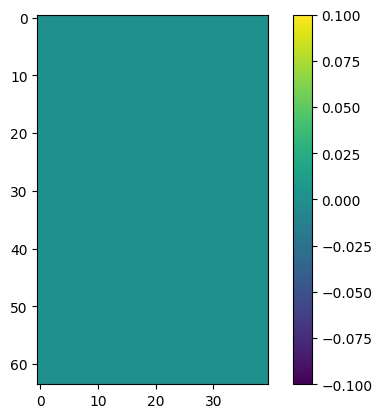

In [27]:
#normalise weights1 row-wise
wt_mat = model.layers[0].weight.data.detach().cpu()
w1_normed=F.normalize(wt_mat,p=2,dim=1)
#visualise w1_normed as heat-map just in absolute values
plt.imshow(w1_normed.abs().numpy())
plt.colorbar()
plt.show()

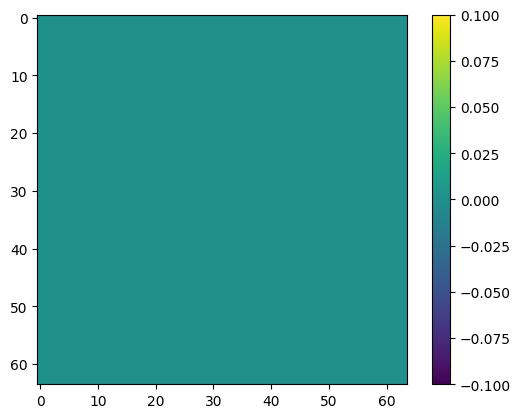

In [28]:
#normalise weights1 row-wise
wt_mat = model.layers[1].weight.data.detach().cpu()
w1_normed=F.normalize(wt_mat,p=2,dim=1)
#visualise w1_normed as heat-map just in absolute values
plt.imshow(w1_normed.abs().numpy())
plt.colorbar()
plt.show()